In [16]:

import argparse
import os
import time
from loguru import logger

import cv2

import torch
import torchvision

from yolox.data.data_augment import ValTransform
from yolox.data.datasets import COCO_CLASSES
from yolox.exp import get_exp
from yolox.utils import fuse_model , get_model_info , postprocess , vis 

from yolox.models import YOLOX , YOLOPAFPN , YOLOXHead

# モデルの定義

In [17]:
params = {
    "depth":1.33,
    "width":1.25,
    "in_channels":[256,512,1024],
    "act":"silu",
    "num_classes":80,
    "device":"cpu",
    "class_names":COCO_CLASSES
}

backbone = YOLOPAFPN( params["depth"], params["width"],in_channels = params["in_channels"],act = params["act"])
head = YOLOXHead( params["num_classes"],params["width"],in_channels = params["in_channels"],act = params["act"])
model = YOLOX( backbone , head )

In [18]:
pth =torch.load("./pth/yolox_x.pth" , map_location=torch.device('cpu') )
model.load_state_dict( pth["model"] )

<All keys matched successfully>

# 細かいセッティング

In [19]:
# 保存フォルダの作成
experiment_name = "sample_test"
output_dir = "./output/"
file_name = os.path.join( output_dir , experiment_name )
os.makedirs( file_name , exist_ok=True)

# 可視化画像を保存するフォルダの作成
vis_folder = os.path.join( file_name ,"visual_result")
os.makedirs( vis_folder , exist_ok=True )

test_size = ( 640 ,640)
logger.info("Model Summary: {}".format(get_model_info(model, test_size)))

model.eval() # modelを評価モードに変更

2022-09-06 23:40:29.996 | INFO     | __main__:<module>:12 - Model Summary: Params: 99.07M, Gflops: 282.46


YOLOX(
  (backbone): YOLOPAFPN(
    (backbone): CSPDarknet(
      (stem): Focus(
        (conv): BaseConv(
          (conv): Conv2d(12, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
      )
      (dark2): Sequential(
        (0): BaseConv(
          (conv): Conv2d(80, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (1): CSPLayer(
          (conv1): BaseConv(
            (conv): Conv2d(160, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act): SiLU(inplace=True)
          )
          (conv2): BaseConv(
            (conv): Conv2d(160, 80, kernel_si

# 画像の読み込み・サイズ変更

In [20]:
class_names = params["class_names"]
num_classes = params["num_classes"]
device = params["device"]

img_path = "./assets/dog.jpg"
img = cv2.imread(img_path)
img_info = {"id": 0}
img_info["file_name"] = os.path.basename(img_path)

height, width = img.shape[:2]
img_info["height"] = height
img_info["width"] = width
img_info["raw_img"] = img

ratio = min( test_size[0]/img.shape[0] , test_size[1]/img.shape[1])
img_info["ratio"] = ratio

img_transformer = ValTransform( legacy= False)
img_reshape , _ = img_transformer( img , None , test_size )
img_reshape = torch.from_numpy(img_reshape).unsqueeze(0)
img_reshape = img_reshape.float()


# 推論の実行

In [21]:

outputs = model( img_reshape )


# 推論後の処理

In [22]:

def postprocess(prediction, num_classes, conf_thre=0.7, nms_thre=0.45, class_agnostic=False):
    box_corner = prediction.new(prediction.shape)
    box_corner[:, :, 0] = prediction[:, :, 0] - prediction[:, :, 2] / 2
    box_corner[:, :, 1] = prediction[:, :, 1] - prediction[:, :, 3] / 2
    box_corner[:, :, 2] = prediction[:, :, 0] + prediction[:, :, 2] / 2
    box_corner[:, :, 3] = prediction[:, :, 1] + prediction[:, :, 3] / 2
    prediction[:, :, :4] = box_corner[:, :, :4]

    output = [None for _ in range(len(prediction))]
    for i, image_pred in enumerate(prediction):

        # If none are remaining => process next image
        if not image_pred.size(0):
            continue
        # Get score and class with highest confidence
        class_conf, class_pred = torch.max(image_pred[:, 5: 5 + num_classes], 1, keepdim=True)

        conf_mask = (image_pred[:, 4] * class_conf.squeeze() >= conf_thre).squeeze()
        # Detections ordered as (x1, y1, x2, y2, obj_conf, class_conf, class_pred)
        detections = torch.cat((image_pred[:, :5], class_conf, class_pred.float()), 1)
        detections = detections[conf_mask]
        if not detections.size(0):
            continue

        if class_agnostic:
            nms_out_index = torchvision.ops.nms(
                detections[:, :4],
                detections[:, 4] * detections[:, 5],
                nms_thre,
            )
        else:
            nms_out_index = torchvision.ops.batched_nms(
                detections[:, :4],
                detections[:, 4] * detections[:, 5],
                detections[:, 6],
                nms_thre,
            )

        detections = detections[nms_out_index]
        if output[i] is None:
            output[i] = detections
        else:
            output[i] = torch.cat((output[i], detections))

    return output


output_postprocessed = postprocess( outputs , num_classes , class_agnostic=True)

# 可視化

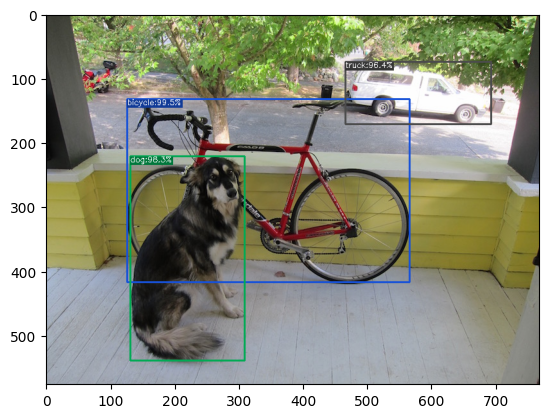

True

In [23]:
import matplotlib.pyplot as plt 

def visual(output, img_info, cls_names, cls_conf=0.35):
    ratio = img_info["ratio"]
    img = img_info["raw_img"]
    if output is None:
        return img
    output = output.cpu()

    bboxes = output[:, 0:4]

    # preprocessing: resize
    bboxes /= ratio

    cls = output[:, 6]
    scores = output[:, 4] * output[:, 5]

    vis_res = vis(img, bboxes, scores, cls, cls_conf, cls_names)
    return vis_res

result_img = visual( output_postprocessed[0], img_info , cls_names=class_names )
result_save_path = os.path.join( vis_folder , "result.png")
plt.imshow( cv2.cvtColor( result_img , cv2.COLOR_BGR2RGB ))
plt.show()
cv2.imwrite( result_save_path , result_img )